# Exploratory Data Analysis
This notebook creates features from raw tables and visualizes the results.

## 1. Set environment
Import libraries

In [1]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
from isodate import parse_duration
from scipy.stats import ttest_ind
from stargazer.stargazer import Stargazer

Read datasets

In [2]:
d1 = pd.read_csv('../../dat/videoDetails.csv')
d2 = pd.read_csv('../../dat/videoFlags.csv')
df = pd.merge(d1, d2, on='videoId', how='right')

## 2. Feature creation
Add constant term

In [3]:
df['const'] = 1

Convert `publishedAt` to datetime format

In [4]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

Turn `definition` to dummy

In [5]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create targets from counters

In [6]:
# Hours (12, 24, 36, ...)
hours = list(np.arange(12, 72+1, 12))

# NCR and sNCR
for h in hours:
    df[f'ncr1Post{h}'] = df[f'post{h}CommentsNeg1'] / df[f'post{h}CommentsNum'].replace(0, 0.1)
    df[f'ncr2Post{h}'] = df[f'post{h}CommentsNeg2'] / df[f'post{h}CommentsNum'].replace(0, 0.1)

Analyze most important words in video titles to create dummy variables

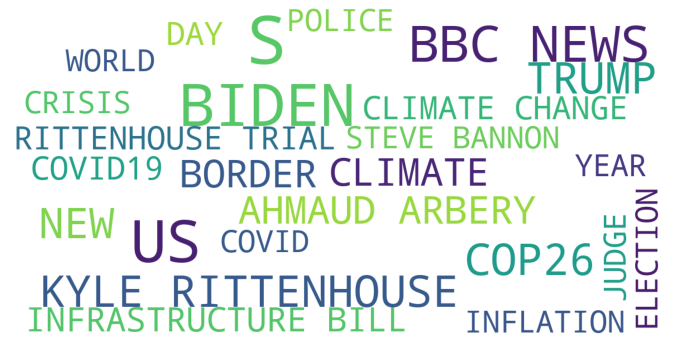

In [7]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()
# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

# Show wordcloud
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [8]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
keywords = {
    'biden':['biden'],
    'trump':['trump'],
    'rittenhouse':['rittenhouse'],
    'climate':['cop26','cop 26','climate'],
    'border':['border'],
    'economy':['inflation','infrastructure'],
    'covid':['covid','covid19','covid-19'],
    'arbery':['arbery'],
    'bannon':['bannon'],
    'usa':['us','u.s','usa','u.s.a']
}

# Create Indicator variables
for topic in keywords:
    words = keywords[topic]
    df[topic] = np.where(df['title'].str.contains('|'.join(words)), 1, 0)

Video title sentiment

In [9]:
clf = SentimentIntensityAnalyzer()
df['titleSentiment'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])

Translate `duration` to seconds.

In [10]:
# YT-duration format to seconds
df['seconds'] = df['duration'].apply(lambda x: int(parse_duration(x).total_seconds()))

# log(seconds)
df['logSeconds'] = np.log(df['seconds'])

Sort data by upload date

In [11]:
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

Treatment indicator

In [12]:
df['treat'] = (df['publishedAt'] > '2021-11-10').astype(int)

Declare running variable $r_i$ and interaction term $r_i \times T_i$
- Before: Seconds until treatment (control was positive, treatment was negative)
- Update: Seconds since treatment (control is negative, treatment is positive)

In [13]:
# Running variable
df['r'] = (df['publishedAt'] - pd.Timestamp('2021-11-10')).dt.total_seconds()

# Interaction
df['rTreat'] = df['r'].multiply(df['treat'])

## 3. EDA
List of targets

### 3.1. Descriptive statistics
Number of available videos as a function of $h$

In [14]:
# post{h}CommentsNum
cols = [f'post{str(h)}CommentsNum' for h in hours]

# Merge to get videoId & post{h}CommentsNum
t = pd.merge(d1[['videoId','publishedAt']], d2[['videoId'] + cols], on='videoId', how='left')

# Create C&T groups
t['treat'] = (t['publishedAt'] > '2021-11-10').astype(int)

# Count available videos per window
t[cols] = t[cols].notna().astype(int)

# Group by
t = t.groupby('treat').agg({**{'videoId':'size'}, **dict(zip(cols,['sum']*6))}).transpose()

# Format
t.index = ['Total videos'] + ['h = ' + str(i*12) for i in range(1,7)]
t

# To latex
# print(t.to_latex(caption='Number of available videos for different values of $h$',
#                  label='tab_dat_nobs'))

treat,0,1
Total videos,831,899
h = 12,678,855
h = 24,583,855
h = 36,463,855
h = 48,428,855
h = 60,344,855
h = 72,319,855


Balance table (conditional on 12$h$)

In [15]:
# Order dummy variables by frequency
X = ['biden','trump','rittenhouse','climate','border','economy','covid','arbery','bannon','usa']
X = df[X].mean().sort_values(ascending=False).index.tolist()

# Add remaining covariates
X = ['titleSentiment','seconds','definition'] + X

# Means by group
t = df.groupby('treat')[X].mean().transpose()

# Calculate p-values of differences
pvals = []
for x in X:
    p = ttest_ind(df.loc[df['treat'].eq(1), x], df.loc[df['treat'].eq(0), x])
    pvals.append(p[1])
t['p'] = pvals

# Change column names
t.columns = ['Control','Treatment','p-value']
t.round(2)

# To latex
# print(t.to_latex(caption='Balance table for videos with comments posted within first 12 hours ('+str(len(df)) + ')',
#                  label='tab_dat_balance', float_format='%.3f'))

,Control,Treatment,p-value
titleSentiment,-0.07,-0.09,0.25
seconds,595.29,642.01,0.64
definition,0.87,0.86,0.67
usa,0.26,0.28,0.28
climate,0.06,0.07,0.58
biden,0.06,0.06,0.94
economy,0.04,0.05,0.19
covid,0.04,0.04,0.58
rittenhouse,0.01,0.06,0.00
trump,0.02,0.04,0.05


Balance table with discontinuous regression

$$X_i = \gamma_0 + \gamma_1 r_i + \gamma_2 T_i + \gamma_3 r_i T_i + V_i$$

In [16]:
# Order frequent-word variables by frequency
Y = ['biden','trump','rittenhouse','climate','border','economy','covid','arbery','bannon','usa']
Y = df[Y].mean().sort_values(ascending=False).index.tolist()

# Add remaining covariates
Y = ['titleSentiment','seconds','definition'] + Y

# Regress each variable on r and treat
data = []
for y in Y:
    m = sm.OLS(endog=df[y], exog=df[['const','r','treat','rTreat']]).fit()
    data.append((m.params['treat'], m.pvalues['treat']))

# Summary table
t = pd.DataFrame(data=data, index=Y, columns=['Estimated Value','p-value'])
t.round(2)

,Estimated Value,p-value
titleSentiment,0.02,0.65
seconds,190.39,0.41
definition,0.08,0.03
usa,0.04,0.43
climate,0.04,0.17
biden,-0.05,0.11
economy,-0.05,0.04
covid,0.03,0.18
rittenhouse,0.10,0.00
trump,0.02,0.32


### 3.2. Visualizations

In [17]:
windows = [f'Post{h}' for h in hours]

Plot raw time series

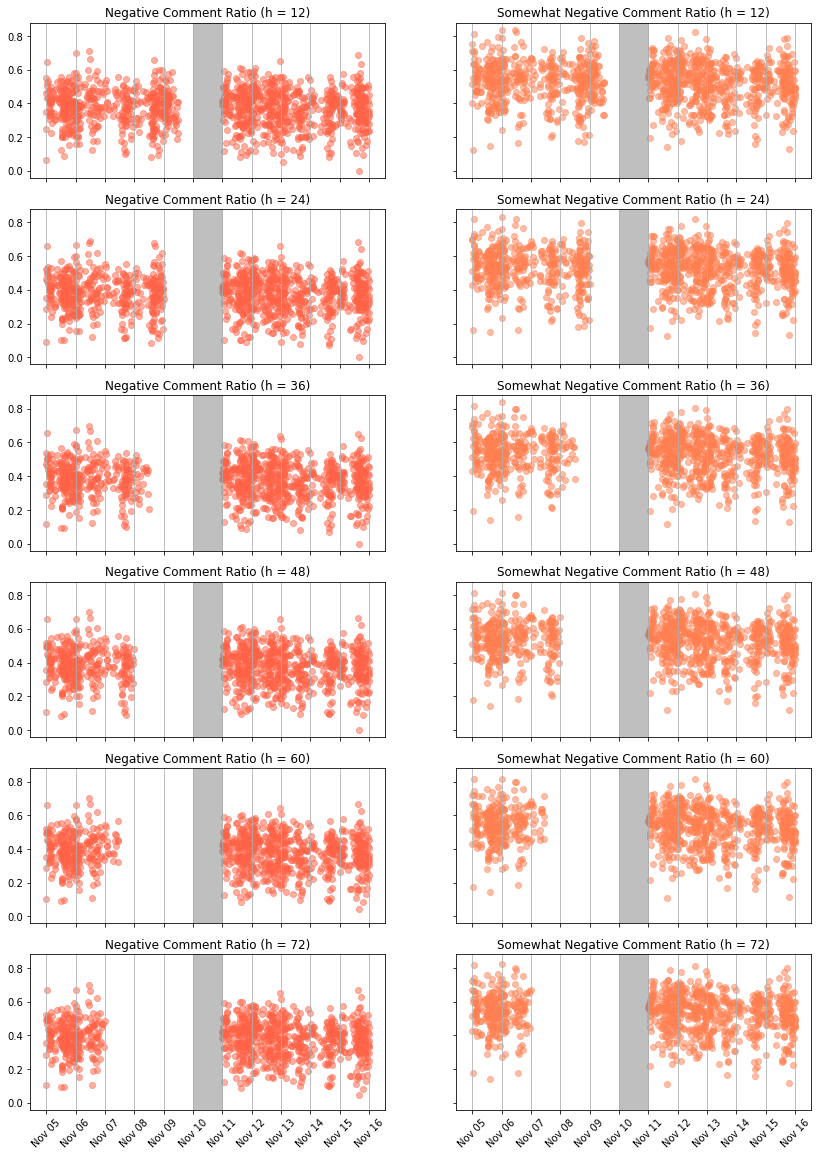

In [18]:
# ncr-like columns
cols = [col for col in df.columns if 'ncr' in col]

# Initialize figure
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(14)

# Plot within each axis
for i, ax in enumerate(axs.flatten()):
    # Only videos with post12CommentsNum > 15
    m = df['post12CommentsNum'].ge(15)
    # Time series
    x = df.loc[m, 'publishedAt']
    y = df.loc[m, cols[i]]
    color = 'tomato' if i % 2 == 0 else 'coral'
    ax.scatter(x, y, alpha=0.5, color=color)
    # Banned treatment region
    ax.axvspan(xmin=pd.Timestamp('2021-11-10'), xmax=pd.Timestamp('2021-11-11'),
               color='grey', alpha=0.5)
    # Ticks and labels
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_tick_params(rotation=45)
    # Aesthetics
    title = 'Negative Comment Ratio' if i % 2 == 0 else 'Somewhat Negative Comment Ratio'
    h = cols[i][-2:]
    ax.set_title(title + ' (h = ' + h + ')')
    ax.grid(which='major', axis='x')
plt.savefig('../../fig/fig_targets.png', dpi=300, bbox_inches='tight')
plt.show()

Figure for presentation

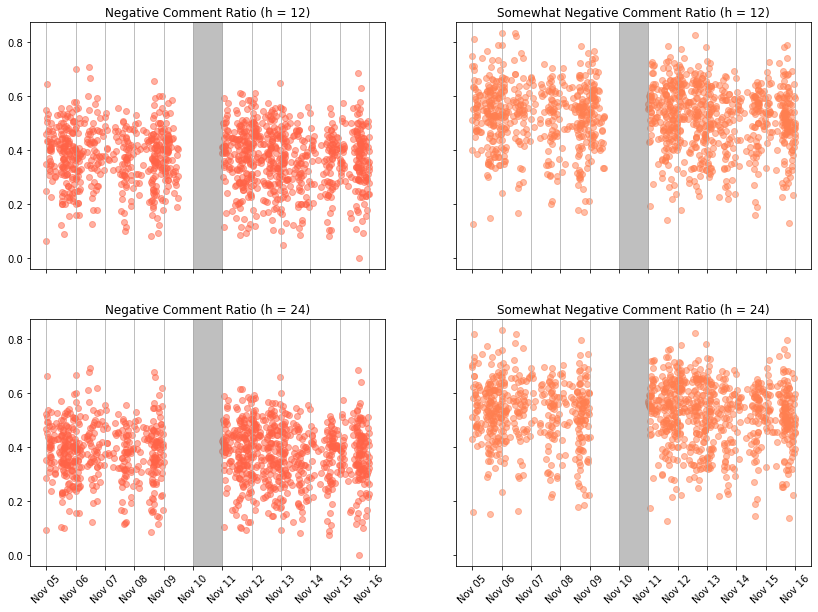

In [19]:
# ncr-like columns
cols = [col for col in df.columns if 'ncr' in col]

# Initialize figure
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(14)

# Plot within each axis
for i, ax in enumerate(axs.flatten()):
    # Only videos with post12CommentsNum > 15
    m = df['post12CommentsNum'].ge(15)
    # Time series
    x = df.loc[m, 'publishedAt']
    y = df.loc[m, cols[i]]
    color = 'tomato' if i % 2 == 0 else 'coral'
    ax.scatter(x, y, alpha=0.5, color=color)
    # Banned treatment region
    ax.axvspan(xmin=pd.Timestamp('2021-11-10'), xmax=pd.Timestamp('2021-11-11'),
               color='grey', alpha=0.5)
    # Ticks and labels
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_tick_params(rotation=45)
    # Aesthetics
    title = 'Negative Comment Ratio' if i % 2 == 0 else 'Somewhat Negative Comment Ratio'
    h = cols[i][-2:]
    ax.set_title(title + ' (h = ' + h + ')')
    ax.grid(which='major', axis='x')
plt.savefig('../../fig/fig_pres_targets.png', dpi=300, bbox_inches='tight')
plt.show()

Average NCR per hourly bin
- Video posted 45 minutes before treatment gets bin = -1 hour
- Video posted 45 minutes after treatment gets bin = 1 hour

$$ncr_i = \beta_0 + \beta_1 r_i + \beta_2 r_i^2 + \beta_3 r_i^3 + T_i(\beta_4 + \beta_5 r_i + \beta_6 r_i^2 + \beta_7 r_i^3)$$

Group data by hourly-bins

In [20]:
# Ceiling of hours until treatment
df['bin'] = df['r'].div(3600).apply(lambda x: floor(x))

# Average NCR
t = df[df['post12CommentsNum'].ge(0)].groupby('bin')[cols].mean()

# Columns for regression
t = t.assign(const = 1,
             r1 = t.index,
             r2 = np.power(t.index, 2),
             r3 = np.power(t.index, 3),
             t = np.where(t.index > 0, 0, 1))
t = t.assign(tr1 = t['t'].multiply(t['r1']),
             tr2 = t['t'].multiply(t['r2']),
             tr3 = t['t'].multiply(t['r3']))

Plot hourly data + d-degree regressions

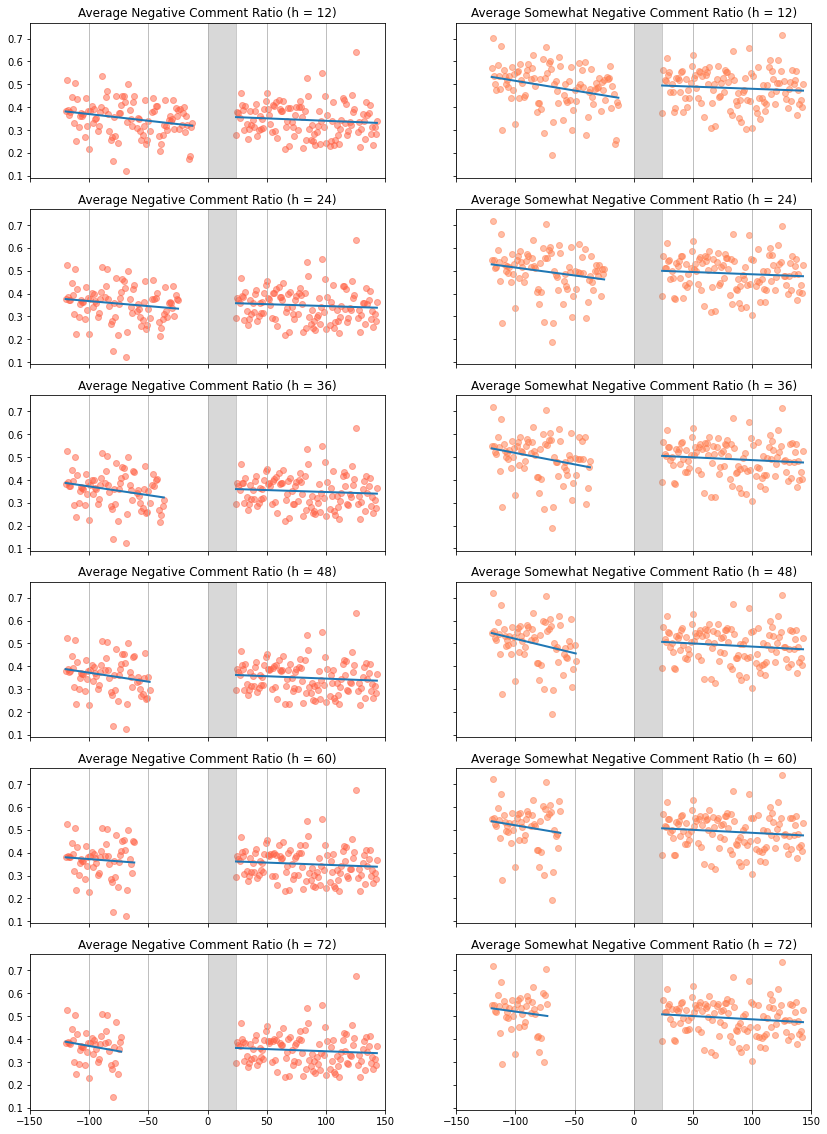

In [21]:
# Initialize figure
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(14)

# Plot within each axis
for i, ax in enumerate(axs.flatten()):
    # Fit regression
    m = sm.OLS(endog=t[t.columns[i]], exog=t[['const','r1','t','tr1']],
               missing='drop').fit()
    # ncr1 => tomato, ncr2 => coral
    color = 'tomato' if i % 2 == 0 else 'coral'
    # Scatter plot
    ax.scatter(t.index, t[t.columns[i]], alpha=0.5, color=color)
    # Plot regression
    ax.plot(m.fittedvalues[t['t'].eq(0)], lw=2, color='C0')
    ax.plot(m.fittedvalues[t['t'].eq(1)], lw=2, color='C0')
    # Banned time span
    ax.axvspan(xmin=0, xmax=24, color='gray', alpha=0.3)
    # Aesthetics
    title = 'Average Negative Comment Ratio' if i % 2 == 0 else 'Average Somewhat Negative Comment Ratio'
    h = cols[i][-2:]
    ax.set_title(f'{title} (h = {h})')
    ax.grid(which='major', axis='x')
    ax.set_xlim(-150, 150)

# Export and show
plt.savefig('../../fig/fig_poly1.png', dpi=300, bbox_inches='tight')
plt.show()

Linear, Quadratic and Cubic plots for presentation

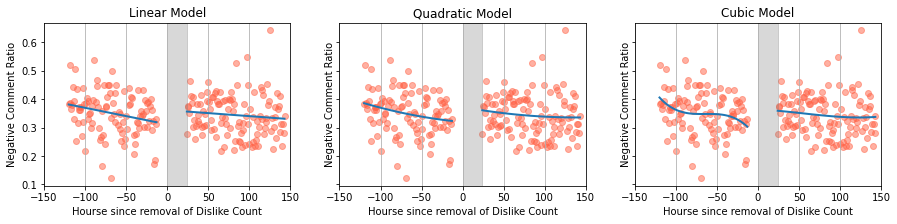

In [22]:
# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_figheight(3)
fig.set_figwidth(15)

# d-degree polynomial
for i, d in enumerate(['1','2','3']):
    title = {'1':'Linear','2':'Quadratic','3':'Cubic'}[d] + ' Model'
    # Fit
    X = [col for col in t.columns if (col[0] in ['r','t']) and ((col == 't') or (col[-1] <= d) or (col[-1] <= d))]
    m = sm.OLS(endog=t['ncr1Post12'], exog=t[['const'] + X]).fit()
    # Scatter
    ax[i].scatter(t.index, t['ncr1Post12'], color='tomato', alpha=0.5)
    # Fitted values
    ax[i].plot(m.fittedvalues[t['t'].eq(1)], lw=2, color='C0')
    ax[i].plot(m.fittedvalues[t['t'].eq(0)], lw=2, color='C0')
    # Banned time region
    ax[i].axvspan(xmin=0, xmax=24, color='gray', alpha=0.3)
    # Aesthetic
    ax[i].set_title(title)
    ax[i].set_xlabel('Hourse since removal of Dislike Count')
    ax[i].set_ylabel('Negative Comment Ratio')
    ax[i].grid(which='major', axis='x')
    ax[i].set_xlim(-150, 150)

# Show
plt.savefig('../../fig/fig_pres_rdds.png', dpi=200, bbox_inches='tight')
plt.show()

## 4. Regression Analysis

### 4.1. Degree 1
$Y_i = \beta_0 + + \beta_1 r_i + \beta_2 T_i + \beta_3 T_i \times R_i + \beta_4 Sentiment_i + u_i$

#### 4.1.1. NCR

In [23]:
X = ['treat','const','r','rTreat','titleSentiment']
m = df['post12CommentsNum'] > 0
models = []
for target in ['ncr1','ncr2']:
    for window in windows:
        m0 = sm.OLS(endog=df.loc[m, target+window], exog=df.loc[m, X], missing='drop')
        m0 = m0.fit(cov_type='HC0')
        models.append(m0)

In [24]:
# Summaries
ncr1 = Stargazer(models[:6])
ncr1.dependent_variable_name('Dependent Variable: Negative Comment Ratio')
ncr1.custom_columns([f'h = {h}' for h in hours], [1]*6)
ncr1.covariate_order(['treat','r','rTreat','titleSentiment','const'])
ncr1.show_degrees_of_freedom(False)
ncr1.add_custom_notes(['Robust standard errors (HC0)'])
ncr1

# Latex output
# print(ncr1.render_latex())

#### 4.1.2. sNCR

In [25]:
# Model summaries
ncr2 = Stargazer(models[6:])
ncr2.dependent_variable_name('Dependent Variable: Somewhat Negative Comment Ratio')
ncr2.custom_columns(['h = ' + str(i*12) for i in range(1,7)], [1]*6)
ncr2.covariate_order(['treat','r','rTreat','titleSentiment','const'])
ncr2.show_degrees_of_freedom(False)
ncr2.add_custom_notes(['Robust standard errors (HC0)'])
ncr2

# Latex output
# print(ncr2.render_latex())